- 특정 기간 동안 투자 종목의 단위 투자 기간(일간, 주간, 월간)의 수익률을 각각 계산
- 구해진 수익률의 표준편차 계산
- 최종 투자 비중 = 제한하기를 원하는 손실 한계(변동성 목표) / 수익률 표준편차
- 나머지 투자 비중 = 현금 보유
- 목표 1% 4.3%/-10.3%
- 목표 2% 5.5%/-24.1%
- 목표 3% 6.3%/-37.6%
- 목표 4% 7.1%/-49.2%
- 목표 5% 7.3%/-59.8%
- 코스피 8.9%/-73.1%

In [1]:
from settings import * 

In [2]:
data_daily = get_data()[['kodex200', 'kbond3y']]
data_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5433 entries, 2000-01-04 to 2021-12-30
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   kodex200  5433 non-null   float64
 1   kbond3y   5433 non-null   float64
dtypes: float64(2)
memory usage: 127.3 KB


In [5]:
data_daily['2002-02']

,kodex200,kbond3y
Date,,
2002-02-01,6514.715,56536.770
2002-02-04,6413.469,56548.880
2002-02-05,6507.500,56586.134
2002-02-06,6516.971,56574.582
2002-02-07,6395.357,56575.548
2002-02-08,6502.791,56607.387
2002-02-14,7049.615,56578.997
2002-02-15,6909.649,56578.406
2002-02-18,6968.457,56616.105


In [6]:
s = '2001-1-30'
e = '2021-12-30'
# e = '2022-02-23'
start = '2002-2-1'

In [7]:
data_daily = data_daily[s:e]

In [9]:
data_daily

,kodex200,kbond3y
Date,,
2001-01-30,5154.203,54262.366
2001-01-31,5399.557,54297.828
2001-02-01,5350.652,54333.248
2001-02-02,5311.437,54420.825
2001-02-05,5046.944,54492.264
...,...,...
2021-12-24,40115.000,111870.000
2021-12-27,39880.000,111935.000
2021-12-28,40205.000,111865.000


In [35]:
# - 특정 기간 동안 투자 종목의 단위 투자 기간(일간, 주간, 월간)의 수익률을 각각 계산
# - 구해진 수익률의 표준편차 계산
# - 최종 투자 비중 = 제한하기를 원하는 손실 한계(변동성 목표) / 수익률 표준편차
# - 나머지 투자 비중 = 현금 보유

# XXX 필요하면 weights를 구해서 WeighTarget Algo로 해도 된다.
class WeighTargetVol(bt.Algo):
    """ 한개의 자산에 대해 즉 포트폴리오의 경우 그 결과에 대해서 TargetVol을 제어한다.

        ** (가정1) 자산 1개와 현금 1개로 구성된 prices DataFrame을 사용한다.
        ** (가정2) 월초 리밸런싱을 가정하고 계산은 전월 종가를 기준으로 계산한다.
    """
    def __init__(self, targetvol=0.01, lookback=6, cash='현금'):
        super(WeighTargetVol, self).__init__()
        self.targetvol = targetvol
        self.lookback = lookback
        self.cash = cash

    def __call__(self, target):
        selected = target.temp['selected'].copy()
        selected.remove(self.cash)
        
        prev_month = target.now - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        prc = target.universe.loc[start:t0, selected].resample('M').last()        

        # 월별 수익률의 변동성
        mret = prc.pct_change().dropna()
        std = mret.std()
#         print(std.values[0], mret)
    

        # H14 : std()
        # N$1 : targetvol
        # -------------------------------------------
        # =IF(H14>N$1, 
        # targetvol보다 변동성이 큰 경우
        #     N$1/H14 * B15/B14           <-- 주식 비중 TargetVol/RealVol
        #     +(1-N$1/H14)*1.03^(1/12),   <-- 현금 비중 (1 - 주식비중)
        # targetvol보다 변동성이 작은 경우
        #     B15/B14 투자비중 1인 경우
        #     )
        #     *K14 이전 수익률
        if std.values[0] > self.targetvol: # targetvol보다 변동성이 큰 경우
            weights = pd.Series(self.targetvol/std, index=selected)
        else:
            weights = pd.Series(1.0, index=selected)
        weights[self.cash] = 1.0 - weights.sum()

        target.temp['weights'] = weights

        return True

In [29]:
selected = ['kodex200']#, 'kbond3y']
prc = data_daily.loc['2001-1':'2002-1', selected].resample('M').last()

In [30]:
prc

,kodex200
Date,
2001-01-31,5399.557
2001-02-28,5001.863
2001-03-31,4524.382
2001-04-30,5037.971
2001-05-31,5298.891
2001-06-30,5104.686
2001-07-31,4678.070
2001-08-31,4715.756
2001-09-30,4126.043


In [31]:
mret = prc.pct_change().dropna()
mret

,kodex200
Date,
2001-02-28,-0.074
2001-03-31,-0.095
2001-04-30,0.114
2001-05-31,0.052
2001-06-30,-0.037
2001-07-31,-0.084
2001-08-31,0.008
2001-09-30,-0.125
2001-10-31,0.130


In [32]:
std = mret.std()
std

kodex200   0.105
dtype: float64

In [34]:
if (std > 0.01).bool():
    print(0.01/std)
else:
    print('False')

kodex200   0.095
dtype: float64


In [28]:
(std > 0.01).any()

True

In [38]:
def strategy_targetvol(name, data, start, targetvol=0.01, months=12, cash='kbond3y'):
    s = bt.Strategy(name, 
            [
                bt.algos.RunMonthly(run_on_end_of_period=False), # !!!월초
                bt.algos.RunAfterDate(start),
                bt.algos.SelectAll(),
                #-------------------------------------------
                WeighTargetVol(targetvol, months, cash),
                #-------------------------------------------
                PrintTempWeights(),
                bt.algos.Rebalance()
            ]
    )
    return bt.Backtest(s, data, initial_capital=100000000.0)

In [39]:
after_date = (datetime.strptime(start, '%Y-%m-%d') - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
after_date

'2002-01-31'

In [40]:
bt목표1 = strategy_targetvol("목표1%", data_daily, after_date, targetvol=0.01)
r = bt.run(bt목표1)

2002-02-01 00:00:00 목표1% kodex200:0.095 kbond3y:0.905 
2002-03-04 00:00:00 목표1% kodex200:0.097 kbond3y:0.903 
2002-04-01 00:00:00 목표1% kodex200:0.105 kbond3y:0.895 
2002-05-02 00:00:00 목표1% kodex200:0.103 kbond3y:0.897 
2002-06-03 00:00:00 목표1% kodex200:0.100 kbond3y:0.900 
2002-07-02 00:00:00 목표1% kodex200:0.098 kbond3y:0.902 
2002-08-01 00:00:00 목표1% kodex200:0.102 kbond3y:0.898 
2002-09-02 00:00:00 목표1% kodex200:0.102 kbond3y:0.898 
2002-10-01 00:00:00 목표1% kodex200:0.103 kbond3y:0.897 
2002-11-01 00:00:00 목표1% kodex200:0.108 kbond3y:0.892 
2002-12-02 00:00:00 목표1% kodex200:0.127 kbond3y:0.873 
2003-01-02 00:00:00 목표1% kodex200:0.120 kbond3y:0.880 
2003-02-03 00:00:00 목표1% kodex200:0.121 kbond3y:0.879 
2003-03-03 00:00:00 목표1% kodex200:0.136 kbond3y:0.864 
2003-04-01 00:00:00 목표1% kodex200:0.155 kbond3y:0.845 
2003-05-02 00:00:00 목표1% kodex200:0.128 kbond3y:0.872 
2003-06-02 00:00:00 목표1% kodex200:0.125 kbond3y:0.875 
2003-07-01 00:00:00 목표1% kodex200:0.124 kbond3y:0.876 
2003-08-01

In [41]:
r.set_date_range(start, e)
r.display()

Stat                 목표1%
-------------------  ----------
Start                2002-02-01
End                  2021-12-30
Risk-free rate       0.00%

Total Return         160.79%
Daily Sharpe         1.22
Daily Sortino        1.99
CAGR                 4.93%
Max Drawdown         -7.67%
Calmar Ratio         0.64

MTD                  1.13%
3m                   -0.18%
6m                   -1.74%
YTD                  -0.12%
1Y                   -0.12%
3Y (ann.)            3.84%
5Y (ann.)            3.99%
10Y (ann.)           3.62%
Since Incep. (ann.)  4.93%

Daily Sharpe         1.22
Daily Sortino        1.99
Daily Mean (ann.)    4.99%
Daily Vol (ann.)     4.10%
Daily Skew           -0.25
Daily Kurt           4.07
Best Day             1.72%
Worst Day            -1.79%

Monthly Sharpe       1.30
Monthly Sortino      2.71
Monthly Mean (ann.)  4.84%
Monthly Vol (ann.)   3.73%
Monthly Skew         -0.16
Monthly Kurt         0.48
Best Month           3.63%
Worst Month          -3.52%

Yearly Sh

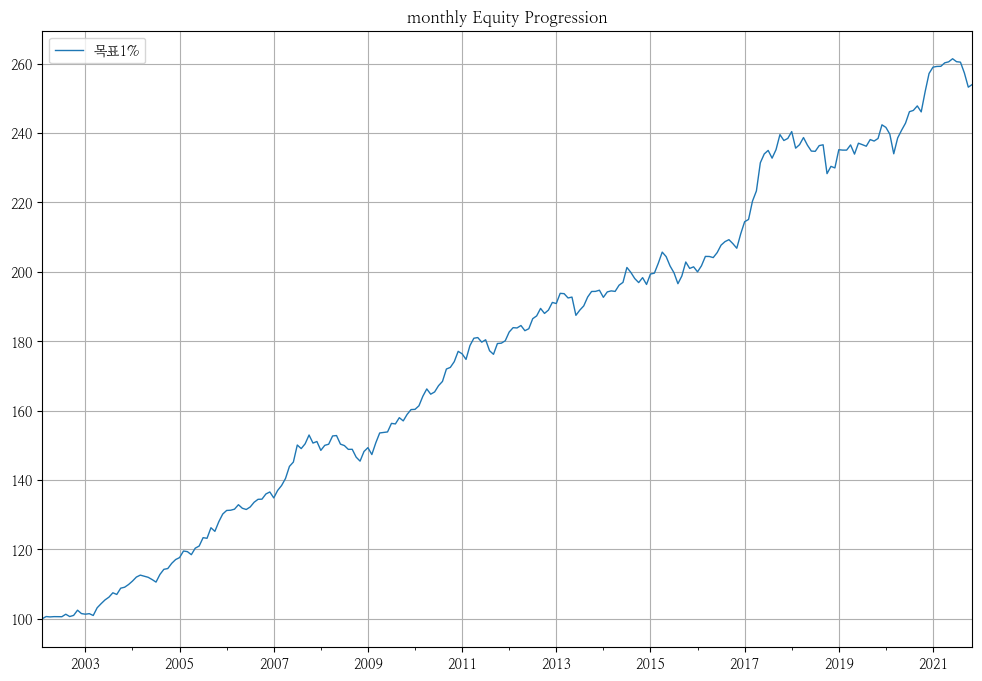

In [42]:
r.plot(freq='M', figsize=(12, 8));

In [44]:
bt_kospi = long_only_ew(data_daily, ['kodex200'], 'kodex200')
r_kospi = bt.run(bt_kospi)

2001-01-30 00:00:00


In [45]:
r_all = bt.run(bt_kospi, bt목표1)
r_all.set_date_range(start)
r_all.display()

Stat                 kodex200    목표1%
-------------------  ----------  ----------
Start                2002-02-01  2002-02-01
End                  2021-12-30  2021-12-30
Risk-free rate       0.00%       0.00%

Total Return         511.99%     160.79%
Daily Sharpe         0.53        1.22
Daily Sortino        0.85        1.99
CAGR                 9.53%       4.93%
Max Drawdown         -52.67%     -7.67%
Calmar Ratio         0.18        0.64

MTD                  6.52%       1.13%
3m                   -0.81%      -0.18%
6m                   -9.05%      -1.74%
YTD                  2.77%       -0.12%
1Y                   2.77%       -0.12%
3Y (ann.)            17.32%      3.84%
5Y (ann.)            10.82%      3.99%
10Y (ann.)           6.81%       3.62%
Since Incep. (ann.)  9.53%       4.93%

Daily Sharpe         0.53        1.22
Daily Sortino        0.85        1.99
Daily Mean (ann.)    11.67%      4.99%
Daily Vol (ann.)     21.87%      4.10%
Daily Skew           -0.01       -0.25
Daily 

          CAGR
kodex200 9.526
목표1%     4.932
             MDD
kodex200 -52.666
목표1%      -7.666


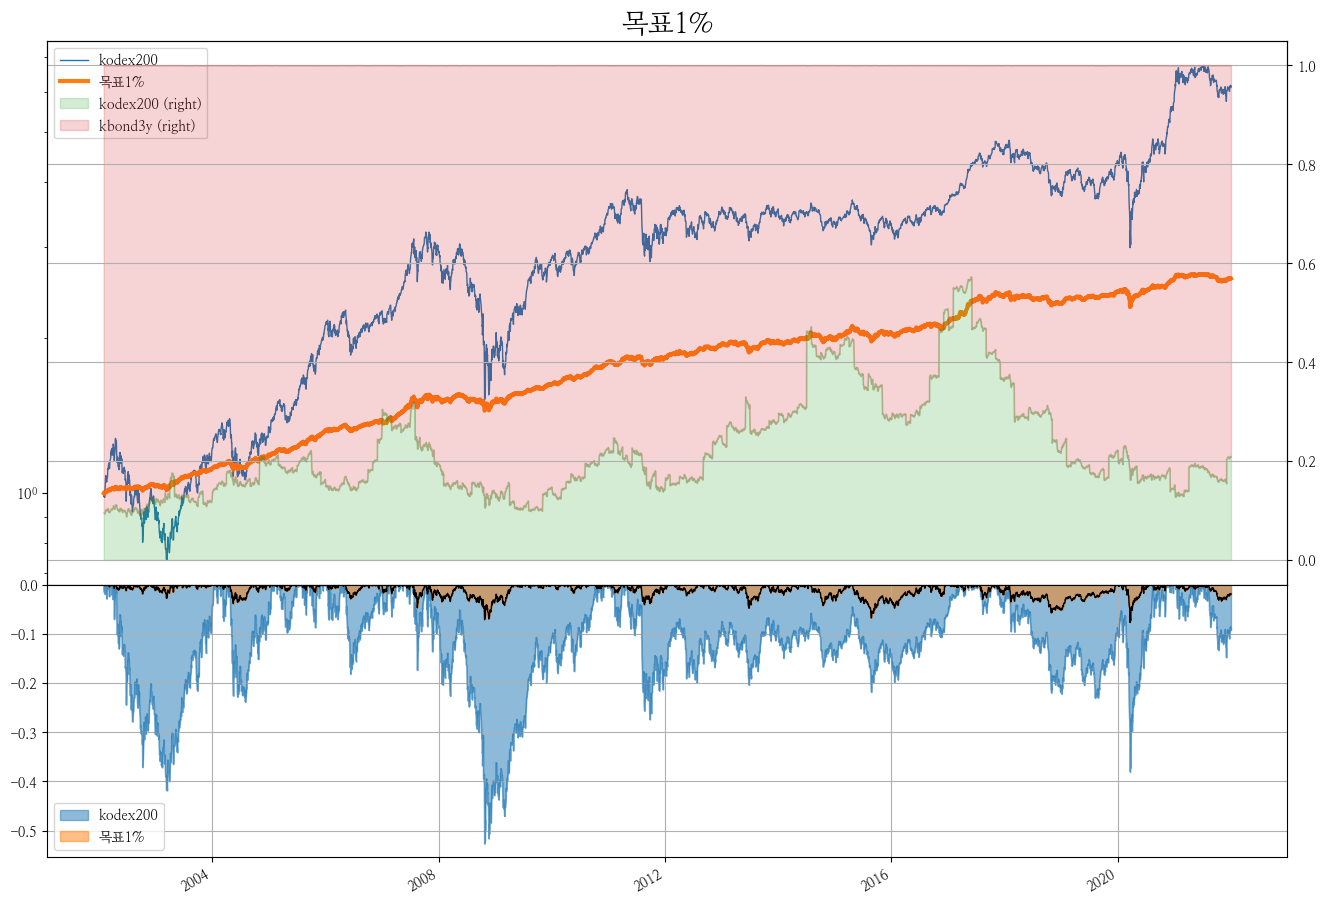

In [46]:
plot_assets(r_all, start, e, "목표1%")

In [47]:
bt목표1 = strategy_targetvol("목표1%", data_daily, after_date, targetvol=0.01)
bt목표2 = strategy_targetvol("목표2%", data_daily, after_date, targetvol=0.02)
bt목표3 = strategy_targetvol("목표3%", data_daily, after_date, targetvol=0.03)
bt목표4 = strategy_targetvol("목표4%", data_daily, after_date, targetvol=0.04)
bt목표5 = strategy_targetvol("목표5%", data_daily, after_date, targetvol=0.05)
r_all = bt.run(bt목표1,bt목표2,bt목표3,bt목표4,bt목표5,bt_kospi)

2002-02-01 00:00:00 목표1% kodex200:0.095 kbond3y:0.905 
2002-03-04 00:00:00 목표1% kodex200:0.097 kbond3y:0.903 
2002-04-01 00:00:00 목표1% kodex200:0.105 kbond3y:0.895 
2002-05-02 00:00:00 목표1% kodex200:0.103 kbond3y:0.897 
2002-06-03 00:00:00 목표1% kodex200:0.100 kbond3y:0.900 
2002-07-02 00:00:00 목표1% kodex200:0.098 kbond3y:0.902 
2002-08-01 00:00:00 목표1% kodex200:0.102 kbond3y:0.898 
2002-09-02 00:00:00 목표1% kodex200:0.102 kbond3y:0.898 
2002-10-01 00:00:00 목표1% kodex200:0.103 kbond3y:0.897 
2002-11-01 00:00:00 목표1% kodex200:0.108 kbond3y:0.892 
2002-12-02 00:00:00 목표1% kodex200:0.127 kbond3y:0.873 
2003-01-02 00:00:00 목표1% kodex200:0.120 kbond3y:0.880 
2003-02-03 00:00:00 목표1% kodex200:0.121 kbond3y:0.879 
2003-03-03 00:00:00 목표1% kodex200:0.136 kbond3y:0.864 
2003-04-01 00:00:00 목표1% kodex200:0.155 kbond3y:0.845 
2003-05-02 00:00:00 목표1% kodex200:0.128 kbond3y:0.872 
2003-06-02 00:00:00 목표1% kodex200:0.125 kbond3y:0.875 
2003-07-01 00:00:00 목표1% kodex200:0.124 kbond3y:0.876 
2003-08-01

In [48]:
r_all.set_date_range(start)
r_all.display()

Stat                 목표1%      목표2%      목표3%      목표4%      목표5%      kodex200
-------------------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2002-02-01  2002-02-01  2002-02-01  2002-02-01  2002-02-01  2002-02-01
End                  2021-12-30  2021-12-30  2021-12-30  2021-12-30  2021-12-30  2021-12-30
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         160.79%     228.80%     269.54%     339.11%     389.19%     511.99%
Daily Sharpe         1.22        0.80        0.63        0.58        0.55        0.53
Daily Sortino        1.99        1.28        1.00        0.93        0.88        0.85
CAGR                 4.93%       6.16%       6.79%       7.71%       8.30%       9.53%
Max Drawdown         -7.67%      -18.59%     -29.06%     -36.99%     -44.65%     -52.67%
Calmar Ratio         0.64        0.33        0.23        0.21        0.19        0.18

MTD                  1.13%      

In [49]:
r_all.prices.resample('M').last().to_drawdown_series().min()*100

목표1%        -5.042
목표2%       -14.353
목표3%       -23.066
목표4%       -31.184
목표5%       -38.079
kodex200   -45.511
dtype: float64

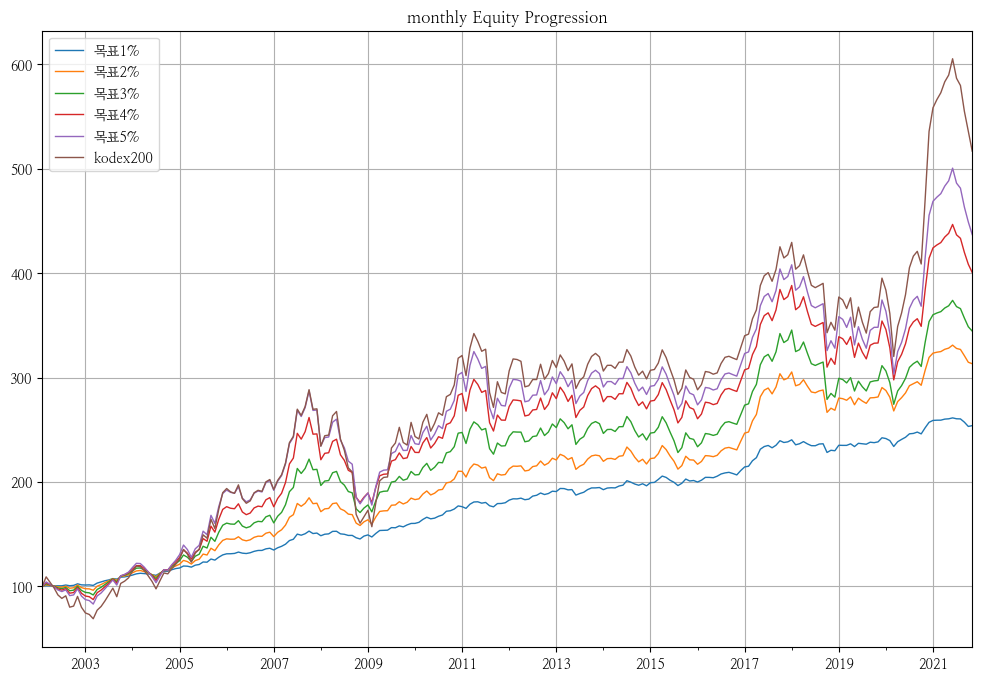

In [50]:
r_all.plot(freq='M', figsize=(12, 8));

          CAGR
목표1%     4.932
목표2%     6.161
목표3%     6.785
목표4%     7.715
목표5%     8.301
kodex200 9.526
             MDD
목표1%      -7.666
목표2%     -18.591
목표3%     -29.058
목표4%     -36.990
목표5%     -44.646
kodex200 -52.666


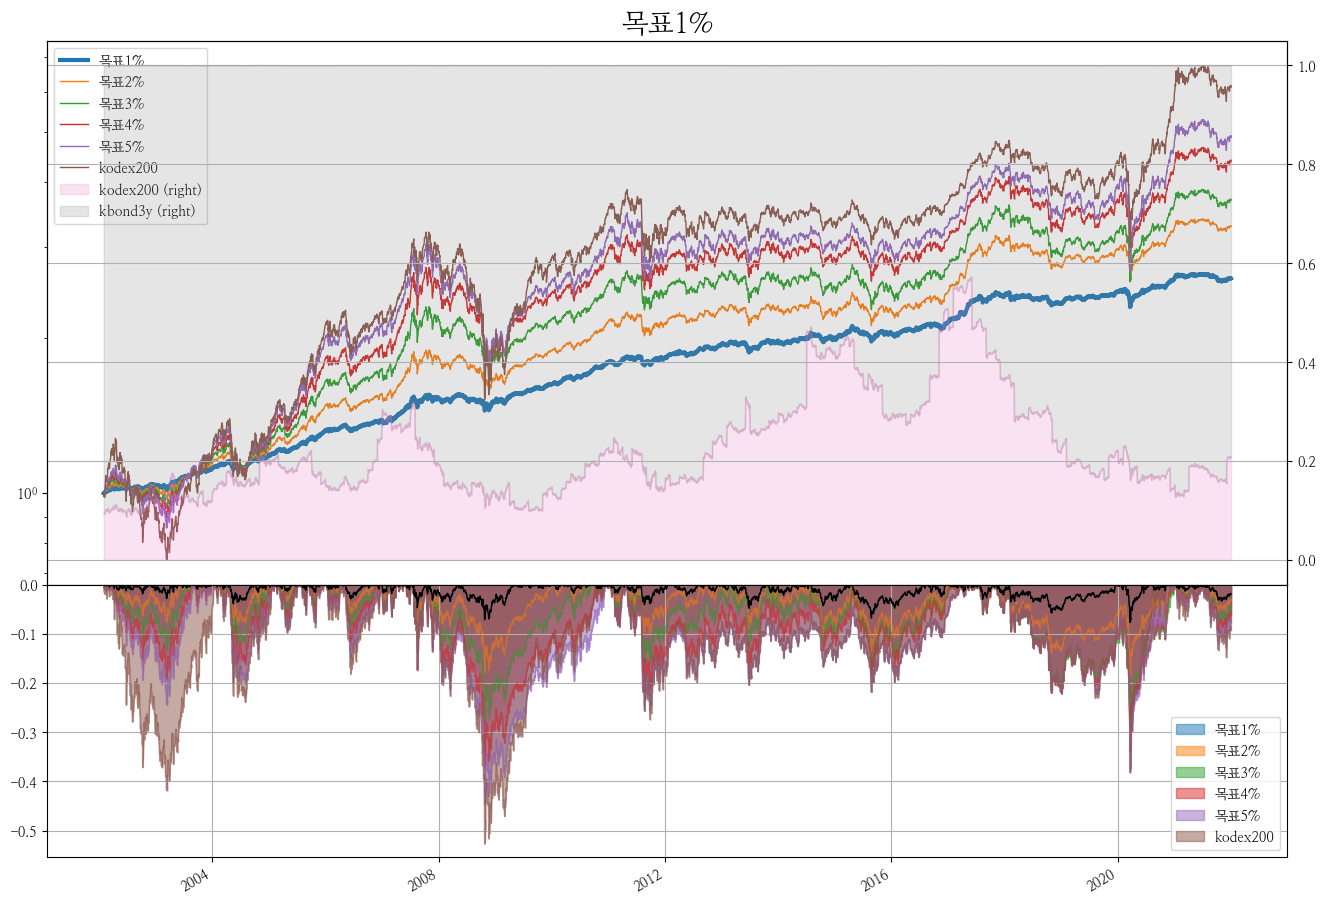

In [51]:
plot_assets(r_all, start, e, "목표1%")